In [1]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
import numpy as np
import scipy
import seaborn as sns
import re
from tqdm.notebook import tqdm
import math

#IMPORTING FUNCTIONS FOR CLASSIFIERS
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier

#IMPORTING FUNCTIONS FOR CLASSIFIERS METRICS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#OPTMIZE PARAMETHERS
import optuna

#IMPORTING FUNCTIONS FROM ./defs

from defs import defs_

In [10]:
#PATHS USED
path_quick_test = [
    "./database_raw/DatasetA/zzzAD1.txt",
    "./database_raw/DatasetA/zzzAD30.txt",
    "./database_raw/DatasetA/zzzAD12.txt",
    "./database_raw/DatasetA/zzzAU.txt",
]

path = glob.glob("./database_raw/DatasetA/zzzA*.txt", recursive=True)

pathB = glob.glob("./database_raw/DatasetB/zzzB*.txt", recursive=True)


In [3]:
def createDatabase(path):
    """
    Take one path and return it in a dataframe
    """
    data = pd.read_csv(path, skiprows=10, sep='\t', dtype='unicode');
    dataframe_initial = pd.DataFrame(data);

    #Quantity of file's columns
    qty_col = len(dataframe_initial.columns);

    #Create array for column's names
    column_label_list = [
        'Time'
    ];

    for j in range(qty_col - 1):
        column_label_list.append('S'+ str(j+1))

    column_label_list.append('Scenario');

    #Import scenario for damage
    scenario_number = getDamageScenarioLabel(path);

    # scenario_array = np.full((qty_row), scenario_number).tolist();
    dataframe_initial['Scenario'] = scenario_number;

    dataframe_initial.columns = column_label_list;
    return dataframe_initial

In [4]:
def df2fft(df_fft,passo_):
    '''
    Função para realizar o FFT.
    Retorna a frequência, spectro, número de observaçoes e o psd
    '''
    n_=len(df_fft)

    fft_calculo=np.fft.fft(df_fft)
    freq=np.fft.fftfreq(n_,d=passo_)
    mascara=freq>0

    fft_abs=2.0*np.abs(fft_calculo/n_)
    psd_calculo=2*(np.abs(fft_calculo/n_)**2)

    s_=fft_abs[mascara] # spectro
    f_=freq[mascara]    # frequencia
    psd_=psd_calculo[mascara]
    # s[0]=s[0]/2

    return f_, s_, n_, psd_


In [5]:
def prepareDatabase(path,number_group = 1024, typeof = 'both') :
    """
    Take [list] of paths to loop through and return the statistical caracteristics in a dataframe
    """

    column_label = [];
    for k in range(30):
        column_label.append('S'+ str(k+1))

    ## First to concatenated Dataframe
    df_first_scenario = createDatabase(path[0]);
    df_first_scenario = df_first_scenario.astype(float);

    df_first_sensor = getStatisticalCaracteristics(df_first_scenario,column_label[0],number_group, typeof);

    for i in range(len(column_label)-1):
        df_first_scenario_sensors = getStatisticalCaracteristics(df_first_scenario,column_label[i+1],number_group, typeof);
        df_first_sensor = pd.concat([df_first_sensor,df_first_scenario_sensors],axis=1)

    df_first_sensor['Scenario'] = getDamageScenarioLabel(path[0]);

    df_final = df_first_sensor

    for i in range(len(path)-1):
        df_scenario = createDatabase(path[i+1]);
        df_scenario = df_scenario.astype(float);

        df_scenario_first_sensor = getStatisticalCaracteristics(df_scenario,column_label[0],number_group, typeof);

        for j in range(len(column_label)-1):
            df_sensor = getStatisticalCaracteristics(df_scenario,column_label[j+1],number_group, typeof);
            df_scenario_first_sensor = pd.concat([df_scenario_first_sensor,df_sensor],axis=1)

        df_scenario_first_sensor['Scenario'] = getDamageScenarioLabel(path[i+1]);

        df_final = pd.concat([df_final,df_scenario_first_sensor], axis=0, ignore_index=True, sort=False);
    
    return df_final

In [6]:
def getStatisticalCaracteristics(original_df, sensor_column_id, qty_group = 1024, typeof = 'both') :
    """
    Take dataframe and Sensor of choice ('S1') and return the calculated statistical characteristics for group of 50 values
    typeof variable is string that needs to be either 'freq', 'time' or 'both'. 'both' is default
    """

    # Sensor column in dataframe 
    timebased_df = original_df[['Time',str(sensor_column_id)]];
    
    # Sensor column in dataframe 
    variable_group = int(qty_group);

    # Columns for freq database
    freq_columns = ['s_max','s_sum','s_mean','s_std','psd_max','psd_sum','psd_mean','f*s_mean','f*s_max','f*s_sum','high_freq','low_freq'];
    # Columns for timebased database
    time_columns = ['mean', 'std', 'median', 'skew', 'amp_max_min', 'kurtosis'];

    # Creating heading for columns
    if (typeof == 'both'):
        head_columns = freq_columns + time_columns;
    elif (typeof == 'freq'):
        head_columns = freq_columns;
    else:
        head_columns = time_columns;
    
    # Heading for columns
    grouped_values = pd.DataFrame(columns=head_columns);
    
    for j in range(int(math.floor(len(timebased_df)/variable_group))) :

        df_iteration = timebased_df[j*variable_group:(j+1)*variable_group]

        if (typeof == 'both' or typeof == 'freq') :
            # Creating variables for freq input
            ##Getting passo from second time - first time
            passo = round((df_iteration['Time'][(j*variable_group)+1] - df_iteration['Time'][j*variable_group]),8)
            f_new, s_new, n_new, psd_new = df2fft(df_iteration[[str(sensor_column_id)]],passo);

            ## NÃO MECHER NA ORDEM, DEVEM SER IGUAL A COLUNAS DO grouped_values
            freq_features = [];
            freq_features.append(s_new.max());
            freq_features.append(s_new.sum());
            freq_features.append(s_new.mean());
            freq_features.append(s_new.std());
            freq_features.append(psd_new.max());
            freq_features.append(psd_new.sum());
            freq_features.append(psd_new.mean());
            freq_features.append((f_new*s_new).mean());
            freq_features.append((f_new*s_new).max());
            freq_features.append((f_new*s_new).sum());
            freq_features.append(f_new[np.argmax(s_new)]);
            freq_features.append(1/(f_new[np.argmax(s_new)]));
        
        if (typeof == 'both' or typeof == 'time') :
            sensor_df = df_iteration[str(sensor_column_id)];

            ## NÃO MECHER NA ORDEM, DEVEM SER IGUAL A COLUNAS DO grouped_values
            time_features = [];
            time_features.append(sensor_df.mean());
            time_features.append(sensor_df.std());
            time_features.append(sensor_df.median());
            time_features.append(sensor_df.skew());
            time_features.append(sensor_df.max() - sensor_df.min());
            time_features.append(pd.Series.kurtosis(sensor_df));
    
        # Creating new row
        if (typeof == 'both'):
            new_row = freq_features + time_features;
        elif (typeof == 'freq'):
            new_row = freq_features;
        else:
            new_row = time_features;
        
        # Creating 'array_features' df with new row data
        array_features = pd.DataFrame([new_row], columns=grouped_values.columns);

        # Concat 'array_features' df in grouped_values
        grouped_values = pd.concat([grouped_values, array_features], ignore_index=True);
    
    new_columns = []
    for i in range(len(grouped_values.columns)):
        new_columns.append(grouped_values.columns[i] + '_' + sensor_column_id)
    grouped_values.columns = new_columns

    return grouped_values;

In [7]:
def getDamageScenarioLabel(path) :
    """
    Take path variable .txt and return int associate in the end of file name.
    Exemple:
    input: ./test/banana123.txt
    return: 123
    """

    regex = re.compile(r'\d+')
    if (path[-5] != 'U'):
        scenario_number = [int(x) for x in regex.findall(path)];
    else :
        scenario_number = [0];

    return scenario_number[0]

In [8]:
def createDatabaseSingleSensor(df_, sensor) :
    """
    Take dataframe from prepareDatabase and a sensor(int) to return the sensor part of the dataframe with damaged or not label
    """
    pd.set_option('mode.chained_assignment', None);

    #Filter dataframe to get only columns related to the sensor
    regex = r'^(Scenario|.*_S' + str(sensor) +')$';
    df_filtered = df_.filter(regex=regex);

    #Transform scenario column into damaged or not column based on the sensor on focus
    transform = lambda x: 1 if x == sensor else 0;
    df_filtered['Scenario'] = df_filtered['Scenario'].apply(transform);
    df_filtered = df_filtered.rename(columns={'Scenario': 'damaged'});
    return df_filtered

In [18]:
samples = 1024;

df_qwer = prepareDatabase(path, samples, typeof='freq');
df_qwer

### time: 5m 36s
### time: 15m 21s

,s_max_S1,s_sum_S1,s_mean_S1,s_std_S1,psd_max_S1,psd_sum_S1,psd_mean_S1,f*s_mean_S1,f*s_max_S1,f*s_sum_S1,...,s_std_S30,psd_max_S30,psd_sum_S30,psd_mean_S30,f*s_mean_S30,f*s_max_S30,f*s_sum_S30,high_freq_S30,low_freq_S30,Scenario
0,0.000778,0.106036,0.000208,0.000162,3.027768e-07,0.000018,3.459908e-08,0.053122,0.397648,13871.182681,...,0.000177,4.662873e-07,0.000018,3.563399e-08,0.051262,0.493473,13385.514565,365.000934,0.002740,1
1,0.000847,0.130239,0.000255,0.000184,3.584794e-07,0.000025,4.949225e-08,0.065218,0.432487,17029.700896,...,0.000147,3.108429e-07,0.000015,2.970490e-08,0.049824,0.402728,13010.161882,399.820880,0.002501,1
2,0.001177,0.123272,0.000241,0.000189,6.922319e-07,0.000024,4.696623e-08,0.061729,0.600990,16118.724848,...,0.000161,3.031221e-07,0.000018,3.431116e-08,0.052961,0.397695,13829.263648,61.972236,0.016136,1
3,0.001212,0.175783,0.000344,0.000245,7.347544e-07,0.000046,8.911312e-08,0.088024,0.619174,22984.924083,...,0.000201,5.667627e-07,0.000029,5.753049e-08,0.069879,0.543804,18246.993571,447.799386,0.002233,1
4,0.001390,0.164442,0.000322,0.000240,9.664138e-07,0.000041,8.053365e-08,0.082345,0.710106,21502.070978,...,0.000172,5.579554e-07,0.000021,4.100327e-08,0.058505,0.539562,15276.911632,114.948503,0.008700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,0.001017,0.150825,0.000295,0.000223,5.176088e-07,0.000035,6.833679e-08,0.073789,0.507735,19267.860854,...,0.000178,4.488054e-07,0.000023,4.459181e-08,0.059948,0.472786,15653.785314,405.273438,0.002467,0
7932,0.000902,0.134070,0.000262,0.000193,4.067090e-07,0.000027,5.311573e-08,0.065592,0.450068,17127.386834,...,0.000163,3.080383e-07,0.000019,3.764928e-08,0.055186,0.391686,14410.321274,202.148438,0.004947,0
7933,0.001324,0.138882,0.000272,0.000203,8.766101e-07,0.000029,5.746810e-08,0.067946,0.660753,17742.219941,...,0.000184,6.345788e-07,0.000025,4.840208e-08,0.062753,0.562184,16386.130810,250.000000,0.004000,0
7934,0.001221,0.141903,0.000278,0.000216,7.459953e-07,0.000032,6.199371e-08,0.069424,0.609543,18128.109374,...,0.000161,3.370660e-07,0.000019,3.797224e-08,0.055919,0.409726,14601.659229,295.898438,0.003380,0


In [11]:
samples = 1024;

df_abcdef = prepareDatabase(path_quick_test, samples, typeof='both');
df_abcdef

,s_max_S1,s_sum_S1,s_mean_S1,s_std_S1,psd_max_S1,psd_sum_S1,psd_mean_S1,f*s_mean_S1,f*s_max_S1,f*s_sum_S1,...,f*s_sum_S30,high_freq_S30,low_freq_S30,mean_S30,std_S30,median_S30,skew_S30,amp_max_min_S30,kurtosis_S30,Scenario
0,0.000778,0.106036,0.000208,0.000162,3.027768e-07,0.000018,3.459908e-08,0.053122,0.397648,13871.182681,...,13385.514565,365.000934,0.002740,-0.000963,0.140511,-0.001607,-0.028262,0.976326,0.374172,1
1,0.000847,0.130239,0.000255,0.000184,3.584794e-07,0.000025,4.949225e-08,0.065218,0.432487,17029.700896,...,13010.161882,399.820880,0.002501,-0.000741,0.132205,0.003108,-0.139601,0.876666,-0.195976,1
2,0.001177,0.123272,0.000241,0.000189,6.922319e-07,0.000024,4.696623e-08,0.061729,0.600990,16118.724848,...,13829.263648,61.972236,0.016136,-0.001060,0.141784,-0.003839,0.152689,0.896421,0.019831,1
3,0.001212,0.175783,0.000344,0.000245,7.347544e-07,0.000046,8.911312e-08,0.088024,0.619174,22984.924083,...,18246.993571,447.799386,0.002233,-0.000610,0.164969,-0.000826,-0.034338,1.078106,-0.092535,1
4,0.001390,0.164442,0.000322,0.000240,9.664138e-07,0.000041,8.053365e-08,0.082345,0.710106,21502.070978,...,15276.911632,114.948503,0.008700,-0.000836,0.139109,0.005241,-0.103854,1.037670,0.058457,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.001017,0.150825,0.000295,0.000223,5.176088e-07,0.000035,6.833679e-08,0.073789,0.507735,19267.860854,...,15653.785314,405.273438,0.002467,0.002227,0.146309,0.004261,-0.060723,0.939671,-0.072852,0
1020,0.000902,0.134070,0.000262,0.000193,4.067090e-07,0.000027,5.311573e-08,0.065592,0.450068,17127.386834,...,14410.321274,202.148438,0.004947,0.001673,0.143202,0.009320,-0.062856,1.032867,0.238116,0
1021,0.001324,0.138882,0.000272,0.000203,8.766101e-07,0.000029,5.746810e-08,0.067946,0.660753,17742.219941,...,16386.130810,250.000000,0.004000,0.001823,0.155409,0.005102,0.127894,1.002445,-0.116651,0
1022,0.001221,0.141903,0.000278,0.000216,7.459953e-07,0.000032,6.199371e-08,0.069424,0.609543,18128.109374,...,14601.659229,295.898438,0.003380,0.001275,0.136255,-0.000052,0.024124,0.837480,-0.053772,0


In [81]:

df_abcdef.to_csv('df_csv/' + str(samples) + '_samples/dataframe_both_simples')
######

In [74]:
# def createScaledDataframeScenario(df_to_scale, analysed_scenario_input: int) :

df_scaled = df_qwer;
analysed_scenario = 1;
# CREATE DATAFRAME WITH 2 PARTS OF SCENARIO received, 1 PARTS OF SCENARIO 0 AND 1 PARTS OF ALL OTHER SCENARIOS    
# CREATE DATAFRAME OF SCENARIO 1
df_damaged = df_scaled.loc[df_scaled['Scenario'] == analysed_scenario];
n_damaged = len(df_damaged);

# CREATE DATAFRAME OF SCENARIO 0
df_undamaged = df_scaled.loc[df_scaled['Scenario'] == 0];
df_undamaged = df_undamaged.sample(n=round(n_damaged/2));
n_undamaged = len(df_undamaged);

# CREATE DATAFRAME OF ALL SCENARIOS
df_random_scenarios = df_scaled.loc[df_scaled['Scenario'] != 0];
df_random_scenarios = df_random_scenarios.loc[df_random_scenarios['Scenario'] != analysed_scenario];
df_random_scenarios = df_random_scenarios.sample(n=round(n_undamaged));

df_ready = pd.concat([df_damaged, df_undamaged],axis=0);
df_ready = pd.concat([df_ready, df_random_scenarios],axis=0);

df_ready = df_ready.reset_index().drop(columns=['index']);

# df_ready = createDatabaseSingleSensor(df_ready, analysed_scenario);
# def createDatabaseSingleSensor(df_, sensor) :
"""
Take dataframe from prepareDatabase and a sensor(int) to return the sensor part of the dataframe with damaged or not label
"""
pd.set_option('mode.chained_assignment', None);

sensor = analysed_scenario
df_ = df_ready
#Filter dataframe to get only columns related to the sensor
regex = r'^(Scenario|.*_S' + str(sensor) +')$';
df_filtered = df_.filter(regex=regex);

#Transform scenario column into damaged or not column based on the sensor on focus
transform = lambda x: 1 if x == sensor else 0;
df_filtered['Scenario'] = df_filtered['Scenario'].apply(transform);
df_filtered = df_filtered.rename(columns={'Scenario': 'damaged'});
df_ready = df_filtered
    # return df_filtered

df_ready
    # return df_ready


,s_max_S1,s_sum_S1,s_mean_S1,s_std_S1,psd_max_S1,psd_sum_S1,psd_mean_S1,f*s_mean_S1,f*s_max_S1,f*s_sum_S1,high_freq_S1,low_freq_S1,damaged
0,0.000778,0.106036,0.000208,0.000162,3.027768e-07,0.000018,3.459908e-08,0.053122,0.397648,13871.182681,376.000963,0.002660,1
1,0.000847,0.130239,0.000255,0.000184,3.584794e-07,0.000025,4.949225e-08,0.065218,0.432487,17029.700896,185.916709,0.005379,1
2,0.001177,0.123272,0.000241,0.000189,6.922319e-07,0.000024,4.696623e-08,0.061729,0.600990,16118.724848,121.945368,0.008200,1
3,0.001212,0.175783,0.000344,0.000245,7.347544e-07,0.000046,8.911312e-08,0.088024,0.619174,22984.924083,509.771622,0.001962,1
4,0.001390,0.164442,0.000322,0.000240,9.664138e-07,0.000041,8.053365e-08,0.082345,0.710106,21502.070978,184.917157,0.005408,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.000843,0.104552,0.000205,0.000154,3.549500e-07,0.000017,3.278248e-08,0.051151,0.420455,13356.568457,15.625000,0.064000,0
508,0.001147,0.136822,0.000268,0.000206,6.583429e-07,0.000029,5.702757e-08,0.068305,0.584300,17835.785463,453.404018,0.002206,0
509,0.000975,0.134048,0.000262,0.000192,4.757706e-07,0.000027,5.274452e-08,0.065581,0.486782,17124.650034,309.570312,0.003230,0
510,0.001093,0.136322,0.000267,0.000201,5.967813e-07,0.000029,5.580290e-08,0.066694,0.545185,17415.079785,458.984375,0.002179,0


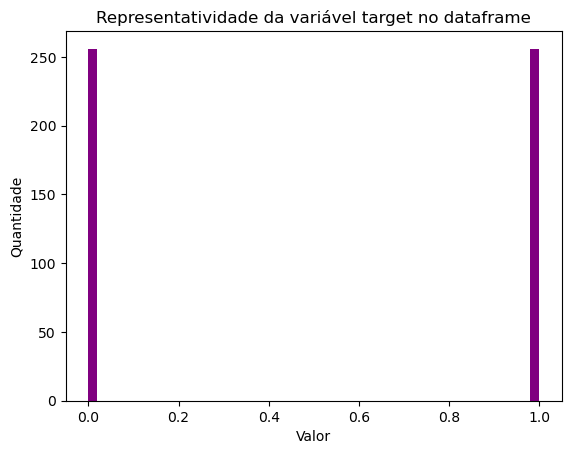

In [72]:
# Check values from database's target 
plt.figure()
plt.title("Representatividade da variável target no dataframe");
plt.xlabel('Valor');
plt.ylabel('Quantidade');

plt.hist(df_filtered['damaged'].astype(int),bins = 50,color='purple');

# Modelo sem Cross validation

### Preparação dos inputs e target

In [75]:
### Setting X and y for model score:0.5545965387932191

print('Scenario is: ' + str(1))

# Setting target variable
y_new_attemp = df_ready['damaged'];
y_new_attemp = y_new_attemp.astype(int);

# Setting other variables
X_new_attemp = df_ready.drop(columns=['damaged']);
X_new_attemp = X_new_attemp.astype(float);

# Separate database for test and train and 
X_train, X_test, y_train, y_test = train_test_split(X_new_attemp, y_new_attemp, test_size=0.3, shuffle=True);

#Scale df
std_scaler = StandardScaler()
X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index);
X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index);

print('X_scaled_train, y_train e X_scaled_test, y_test estão prontos.')

Scenario is: 1
X_scaled_train, y_train e X_scaled_test, y_test estão prontos.


### Treinando modelo sem otimização

In [76]:
### DEFAULT PARAMETHERS ON FULL DATAFRAME
rf = RandomForestClassifier(n_estimators = 5000);
rf.fit(X_scaled_train,y_train);

### Predict df test
y_pred = rf.predict(X_scaled_test);
accuracy_test = accuracy_score(y_test, y_pred);
print('Preformance de previsão de df de teste: ' + "{:.4f}".format(accuracy_test))

### Predict df train (overfit)
y_pred = rf.predict(X_scaled_train);
accuracy_train = accuracy_score(y_train, y_pred);
print('Performance de previsão de df de treino: ' + "{:.4f}".format(accuracy_train))
if (accuracy_train > accuracy_test) :
    print('-> overfit(?)')

Preformance de previsão de df de teste: 0.5455
Performance de previsão de df de treino: 1.0000
-> overfit(?)


# Modelo com Cross validation

### Preparação dos inputs e target

In [78]:
### Setting X and y for model

print('Scenario is: ' + str(1))

# Setting target variable
y_new_attemp = df_ready['damaged'];
y_new_attemp = y_new_attemp.astype(int);

# Setting other variables
X_new_attemp = df_ready.drop(columns=['damaged']);
X_new_attemp = X_new_attemp.astype(float);

#Scale df
std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X_new_attemp), columns=X_new_attemp.columns, index=X_new_attemp.index);

print('X_scaled e y_new_attemp estão prontos.')

Scenario is: 1
X_scaled e y_new_attemp estão prontos.


In [79]:
### DEFAULT PARAMETHERS ON FULL DATAFRAME
score_new_attemp = cross_val_score(XGBClassifier(n_estimators = 1000), X_scaled, y_new_attemp);

print('Performance da media das validações cruzadas: ' + "{:.4f}".format(np.mean(score_new_attemp)))

Performance da media das validações cruzadas: 0.5157


In [7]:
## First to concatenated Dataframe
df_first_scenario = createDatabase(path[0]);
df_first_scenario = df_first_scenario.astype(float);
df_first_scenario

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S22,S23,S24,S25,S26,S27,S28,S29,S30,Scenario
0,0.000000,0.004954,-0.001359,0.004767,-0.008527,-0.001187,0.004383,-0.000652,-0.031577,-0.007815,...,-0.001459,0.002673,-0.001023,0.000871,-0.003662,0.005480,-0.004954,0.003155,-0.002783,1.0
1,0.000977,-0.002692,0.013224,-0.012159,0.006356,-0.010569,0.005803,-0.010348,0.051244,-0.015238,...,-0.000039,-0.002362,0.001403,0.000519,-0.003883,-0.001152,0.009068,-0.002660,-0.000935,1.0
2,0.001953,0.010440,-0.017548,-0.002409,-0.023680,0.003805,-0.014305,0.028052,-0.001950,0.022934,...,-0.001821,0.009181,-0.000987,0.004117,-0.005031,0.006924,0.008966,0.006289,-0.002047,1.0
3,0.002930,-0.019787,0.005273,-0.003471,0.004499,-0.023611,0.004459,0.012805,0.028606,0.009633,...,0.007827,0.000538,0.009287,0.000920,-0.001098,-0.002596,0.013369,-0.001364,0.003097,1.0
4,0.003906,-0.003796,0.006211,0.000715,-0.000022,-0.008824,0.017145,0.012718,0.042087,0.010510,...,-0.005141,0.011082,-0.003525,0.011010,-0.005374,0.007329,-0.007782,0.008712,-0.000247,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,255.995100,-0.297023,-0.151547,-0.059725,-0.052962,-0.297202,0.107587,0.199612,0.491991,0.153046,...,0.048218,-0.073839,0.133619,0.008002,-0.060962,0.048361,0.048781,-0.092742,-0.042226,1.0
262140,255.996100,-0.176614,-0.045884,-0.260080,-0.126670,0.095408,0.062842,0.494932,-0.122551,0.560416,...,-0.121218,0.056468,-0.205697,0.151583,0.283892,0.174469,-0.123170,0.003544,0.222709,1.0
262141,255.997100,0.087201,-0.129184,-0.344268,-0.285500,-0.154741,0.191804,0.207104,0.116178,-0.001026,...,-0.168463,-0.180225,0.017537,0.009359,0.048651,-0.055765,0.149840,0.242089,-0.074097,1.0
262142,255.998000,0.075681,-0.057447,0.126385,0.144944,-0.087632,0.256604,-0.060432,0.362550,0.015992,...,-0.145095,-0.200837,-0.118993,-0.097636,-0.020304,0.162171,0.254490,-0.036783,-0.073573,1.0


In [9]:
df_freq_s1 = df_first_scenario[['S1']]
df_freq_s1

,S1
0,0.004954
1,-0.002692
2,0.010440
3,-0.019787
4,-0.003796
...,...
262139,-0.297023
262140,-0.176614
262141,0.087201
262142,0.075681


In [11]:
samples = 1024
df_freq_s1 = df_first_scenario[['Time','S1']]

df_iteration = df_freq_s1[:1024]
j=0
passo = round((df_iteration['Time'][(j*samples)+1] - df_iteration['Time'][j*samples]),8)

df_iteration = df_iteration['S1']
f, s, n, psd = defs_.df2fft(df_iteration,passo);

f, s, n, psd

(array([  1.00000256,   2.00000512,   3.00000768,   4.00001024,
          5.0000128 ,   6.00001536,   7.00001792,   8.00002048,
          9.00002304,  10.0000256 ,  11.00002816,  12.00003072,
         13.00003328,  14.00003584,  15.0000384 ,  16.00004096,
         17.00004352,  18.00004608,  19.00004864,  20.0000512 ,
         21.00005376,  22.00005632,  23.00005888,  24.00006144,
         25.000064  ,  26.00006656,  27.00006912,  28.00007168,
         29.00007424,  30.0000768 ,  31.00007936,  32.00008192,
         33.00008448,  34.00008704,  35.0000896 ,  36.00009216,
         37.00009472,  38.00009728,  39.00009984,  40.0001024 ,
         41.00010496,  42.00010752,  43.00011008,  44.00011264,
         45.0001152 ,  46.00011776,  47.00012032,  48.00012288,
         49.00012544,  50.000128  ,  51.00013056,  52.00013312,
         53.00013568,  54.00013824,  55.0001408 ,  56.00014336,
         57.00014592,  58.00014848,  59.00015104,  60.0001536 ,
         61.00015616,  62.00015872,  63.

In [15]:
1/(f[np.argmax(s)])

0.004975111641791045

In [104]:
## NÃO MECHER NA ORDEM, DEVEM SER IGUAL A COLUNAS DO grouped_values
freq_features = [];
freq_features.append(s.max());
freq_features.append(s.sum());
freq_features.append(s.mean());
freq_features.append(s.std());
freq_features.append(psd.max());
freq_features.append(psd.sum());
freq_features.append(psd.mean());

freq_features

[0.0017098931640625,
 0.514871739328125,
 0.0005037883946459149,
 0.00036465933472807325,
 1.4618673162538337e-06,
 0.00019764415943894105,
 1.9338958849211452e-07]

# Importing Database

(0.0, 1024.0)

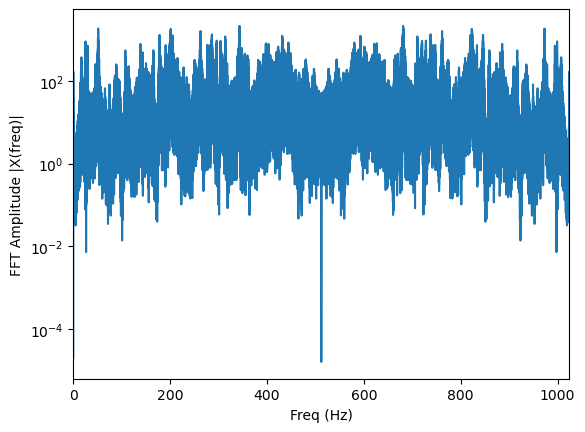

In [62]:
X = fft(df_timebased_s1['S1'])
N = len(X)
n = np.arange(N)
T = N/1024
freq = n/T
plt.semilogy(freq,np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 1024)

In [21]:
X = fft(df_timebased_s1['S1'][1024:2048])
N = len(X)
n = np.arange(N)
T = N/1024
freq = n/T
plt.semilogy(freq,np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 512)

NameError: name 'df_timebased_s1' is not defined

In [65]:
X.max()

(33.73384673097476+15.125119108784217j)

In [ ]:
X = fft(df_timebased_s1['S1'])
N = len(X)
n = np.arange(N)
T = N/1024
freq = n/T
plt.semilogy(freq,np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 512)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


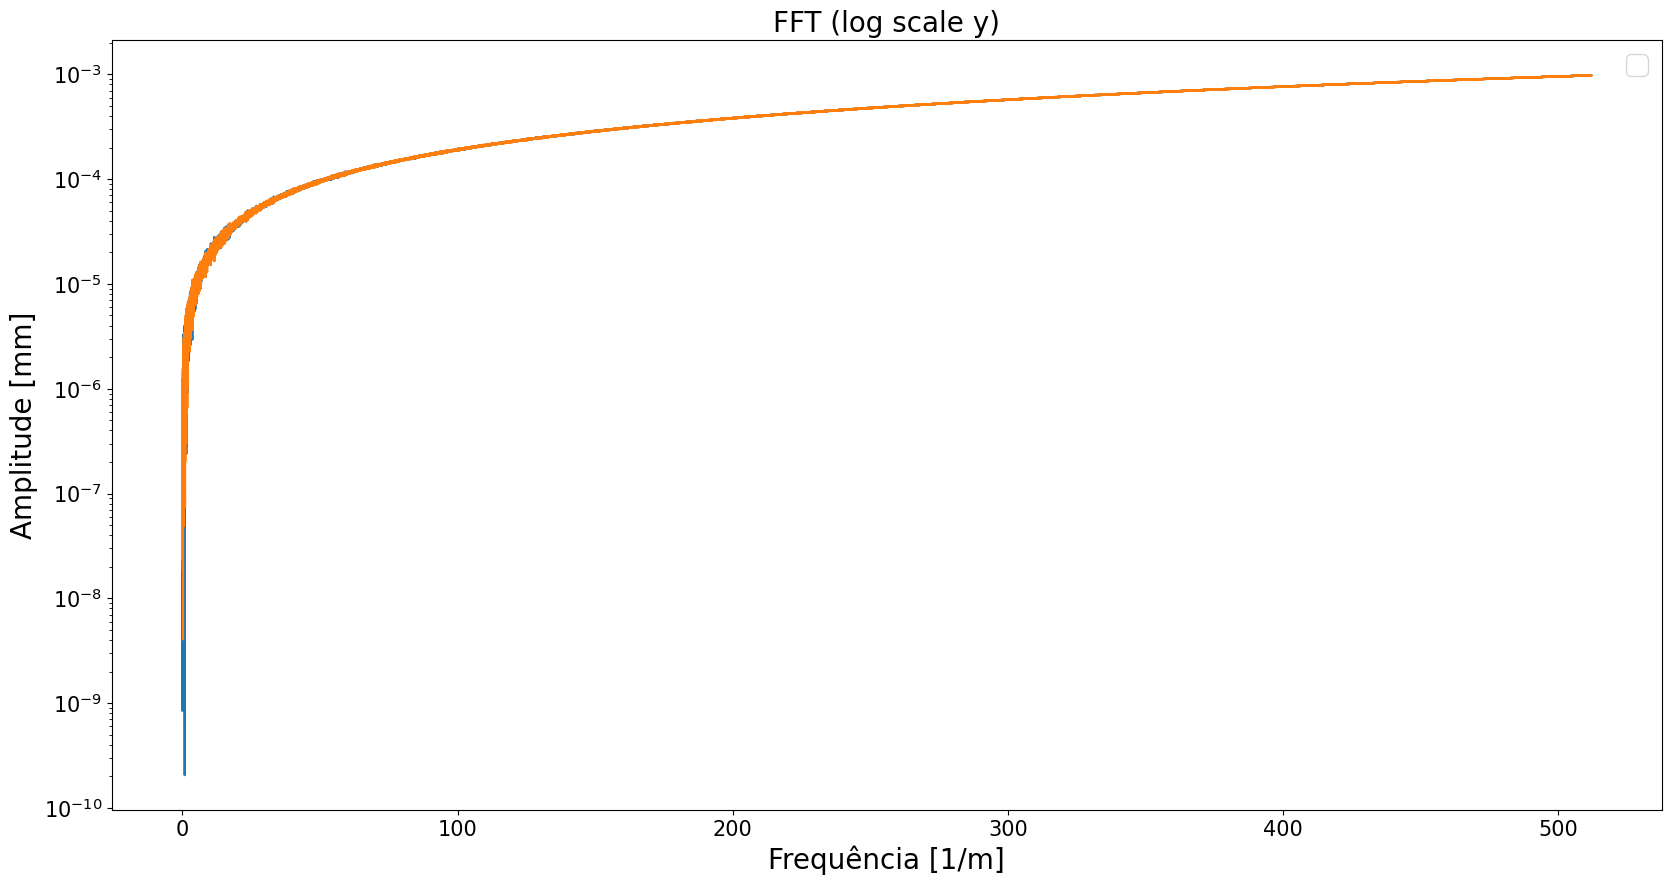

In [42]:
plt.figure(figsize=(20,10))
plt.plot(f,s)
plt.legend(fontsize=20)
plt.xlabel('Frequência [1/m]',fontsize=20)
plt.ylabel('Amplitude [mm]',fontsize=20)
plt.yscale('log')
plt.title('FFT (log scale y)',fontsize=20)
plt.tick_params(labelsize=15)

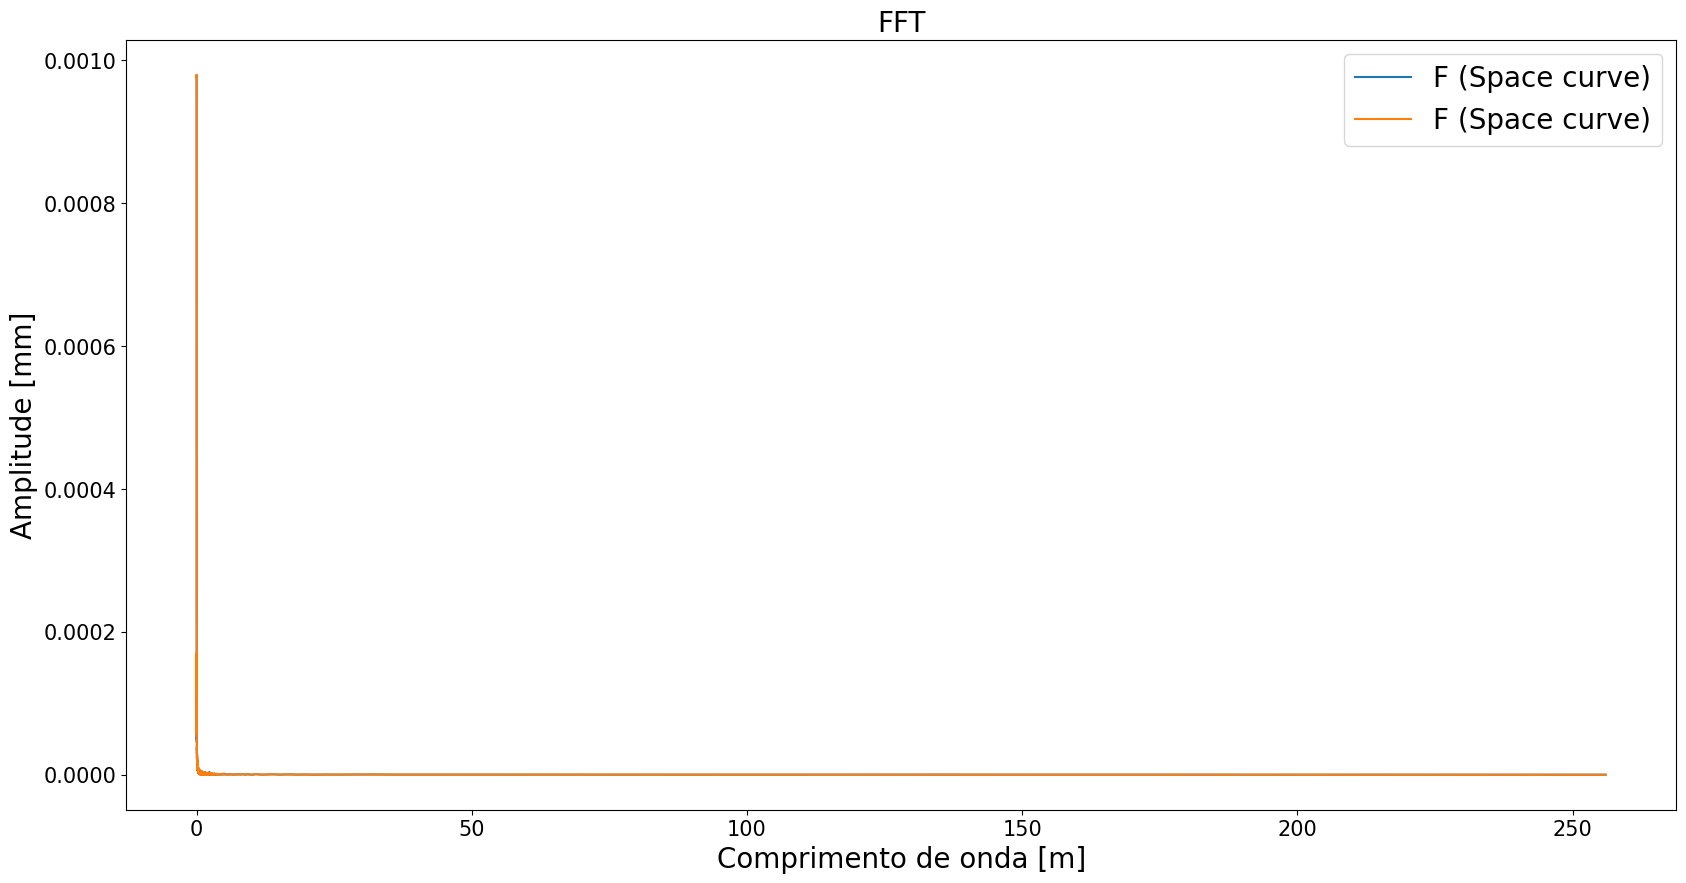

In [43]:
plt.figure(figsize=(20,10))
plt.plot(1/f,s,label='F (Space curve)')
plt.legend(fontsize=20)
plt.xlabel('Comprimento de onda [m]',fontsize=20)
plt.ylabel('Amplitude [mm]',fontsize=20)
# plt.xlim(0,10)
plt.title('FFT',fontsize=20)
plt.tick_params(labelsize=15)
# plt.xlim(0,150)

In [27]:
#taxa de amostragem
fs = 1/(df_df['Time'][1] - df_df['Time'][0]);
round(fs)

# numero de pontos na janela || possivelmente aumentar = 1000
np = 1000;

delta_f = fs/np
delta_f



# f1,s1,n1,psd1 = df2fft(df_df['S1'] , passo)

1.024